In [1]:
!pip install tensorflow==2.15.0


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import pandas as pd
import numpy as np
import datetime
import random

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models 
from tensorflow.keras import callbacks as tf_callbacks

from IPython.display import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [4]:
# labels dataframe preparation
labels=pd.read_csv(r'G:\University\DACNTT\dog-breed-identification\labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
dog_classes = ["beagle", "chihuahua", "miniature_poodle", "bull_mastiff", "doberman", 
              "dandie_dinmont", "dandie_bulldog", "pomeranian", "golden_retriever", "malamute",
              "miniature_pinscher", "miniature_poodle", "pembroke", "pug", "siberian_husky", 
              "staffordshire_bullterrier", "toy_poodle", "yorkshire_terrier", "labrador_retriever", 
              "eskimo_dog", "irish_terrier", "malinois", "maltese_dog", "norfolk_terrier"]
labels = labels[labels['breed'].isin(dog_classes)].reset_index(drop=True)

In [6]:
labels

,id,breed
0,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
1,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,0075dc49dab4024d12fafe67074d8a81,norfolk_terrier
3,008b1271ed1addaccf93783b39deab45,doberman
4,00a366d4b4a9bbb6c8a63126697b7656,golden_retriever
...,...,...
1876,ff6f47aa8e181b6efa4d0be7b09b5628,golden_retriever
1877,ff7d9c08091acc3b18b869951feeb013,maltese_dog
1878,ffa0055ec324829882186bae29491645,maltese_dog
1879,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont


In [7]:
breed = labels.groupby(by='breed').agg({'id':'count'})
breed.sort_values(by='id', ascending=False)

,id
breed,
maltese_dog,117
pomeranian,111
beagle,105
miniature_pinscher,102
siberian_husky,95
pug,94
pembroke,92
dandie_dinmont,89
labrador_retriever,84


In [9]:
labels["id"].head(1)

0    0021f9ceb3235effd7fcde7f7538ed62
Name: id, dtype: object

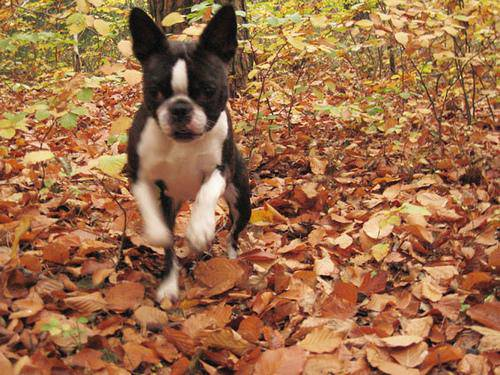

In [8]:
Image(r'G:\University\DACNTT\dog-breed-identification\train/000bec180eb18c7604dcecc8fe0dba07.jpg')

In [9]:
filenames = [r'G:\University\DACNTT\dog-breed-identification\train/' + fname + '.jpg' for fname in labels['id'] ]
len(filenames)

1881

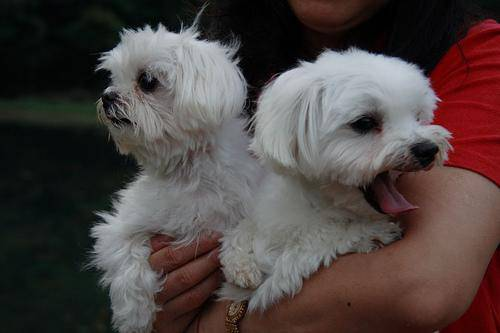

In [10]:
Image(filenames[1131])

In [11]:
X = filenames
y = labels['breed']

In [12]:
y = pd.get_dummies(y)
encoding_labels = y.columns
y=y.to_numpy()

In [13]:
y.shape

(1881, 22)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

len(X_train), len(y_train), len(X_val), len(y_val)

(1504, 1504, 377, 377)

# Preprocessing images 



In [15]:
img_size = 224
batch_size = 32

In [21]:
def prepare_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[img_size, img_size])
    return image

def get_label_image(image_path, label):
    image = prepare_image(image_path)
    return image, label

def create_batches(X, y=None, batch_size=batch_size, valid_data=False, test_data=False):
    if test_data:
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X))
        data_batch = data.map(prepare_image).batch(batch_size)
    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.map(get_label_image).batch(batch_size)
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_label_image).batch(batch_size)
    return data_batch

In [22]:
train_data = create_batches(X_train, y_train)
valid_data = create_batches(X_val, y_val, valid_data=True)

## Model preparation

In [23]:
input_shape = [None, img_size, img_size, 3]
output_shape = len(encoding_labels)

num_epochs = 40

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=3)

In [25]:
NUM_CLASSES = y.shape[1]
IMG_SIZE = 224

base_model = EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation=None),
    layers.Dropout(0.5),
    layers.ReLU(),
    layers.Dense(256, activation=None),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

base_model.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
hist = model.fit(train_data, epochs=40, validation_data=valid_data, validation_freq=1, callbacks=[early_stopping])

Epoch 1/40


47/47 [==============================] - 80s 1s/step - loss: 1.1084 - accuracy: 0.6729 - val_loss: 0.4584 - val_accuracy: 0.8276
Epoch 2/40
47/47 [==============================] - 55s 1s/step - loss: 0.3985 - accuracy: 0.8604 - val_loss: 0.3857 - val_accuracy: 0.8488
Epoch 3/40
47/47 [==============================] - 55s 1s/step - loss: 0.2865 - accuracy: 0.8916 - val_loss: 0.3970 - val_accuracy: 0.8435
Epoch 4/40
47/47 [==============================] - 56s 1s/step - loss: 0.2486 - accuracy: 0.9076 - val_loss: 0.3579 - val_accuracy: 0.8727
Epoch 5/40
47/47 [==============================] - 56s 1s/step - loss: 0.2139 - accuracy: 0.9169 - val_loss: 0.3899 - val_accuracy: 0.8674
Epoch 6/40
47/47 [==============================] - 56s 1s/step - loss: 0.1871 - accuracy: 0.9309 - val_loss: 0.3373 - val_accuracy: 0.8727
Epoch 7/40
47/47 [==============================] - 56s 1s/step - loss: 0.1590 - accuracy: 0.9415 - val_loss: 0.4190 - val_accuracy: 0.8568


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               6

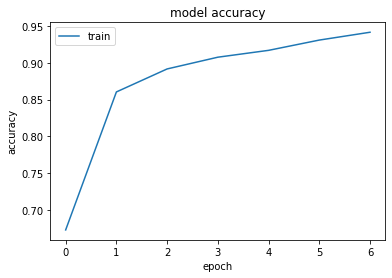

In [28]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [28]:
model.save('/efficientnetb0_dog_classification.keras')

## Predictions

In [5]:
import tensorflow as tf
input_shape = (224, 224, 3)
new_model = tf.keras.models.load_model("/efficientnetb0_dog_classification.keras")

In [4]:
y_pred = new_model.predict(valid_data)

NameError: name 'valid_data' is not defined

In [ ]:
# function for encoding labels
def pred_labels(prediction_propabilities):
    
    return encoding_labels[np.argmax(prediction_propabilities)]
    

In [ ]:
# check a random sample from validation dataset
index = random.randint(0, len(y_val))
label = pred_labels(y_pred[index])

print(f'Is {label} predicted properly? Prediction: {pred_labels(y_val[index])}. So:  {label==pred_labels(y_val[index])}\n')

Image(X_val[index])

NameError: name 'random' is not defined

Đây là giống chó maltese_dog phải không? 
Kết quả dự đoán: maltese_dog. 
Kết luận:  True



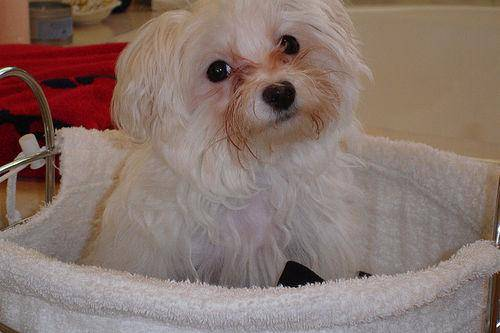

In [69]:
index = random.randint(0, len(y_val))
label = pred_labels(y_pred[index])

print(f'Đây là giống chó {label} phải không? \nKết quả dự đoán: {pred_labels(y_val[index])}. \nKết luận:  {label==pred_labels(y_val[index])}\n')

Image(X_val[index])